In [351]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from numpy import pi, exp
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from itertools import product
import matplotlib.pyplot as plt

In [75]:
EPS = np.finfo(np.float64).eps

In [46]:
# загружаем только числовые признаки, чтобы считать расстояние между объектами
data = pd.read_csv("data/normalized_data_fresh.csv", delimiter=",", decimal=".")
numeric_data = data[["age", "height", "cost", "goals_amount", "minutes_per_game"]]
targets = data["target"]
positions = tuple(set(targets.to_list()))
numeric_data.head(10)

,age,height,cost,goals_amount,minutes_per_game
0,0.347826,0.760870,1.000000,0.70,0.831293
1,0.173913,0.282609,0.447236,0.00,0.047619
2,0.304348,0.391304,0.698492,0.20,0.736996
3,0.217391,0.521739,0.648241,0.35,0.615079
4,0.391304,0.391304,0.899497,0.40,0.781633
5,0.521739,0.673913,0.648241,0.00,0.495238
6,0.217391,0.413043,0.396985,0.15,0.827706
7,0.304348,0.304348,0.547739,0.15,0.646886
8,0.434783,0.478261,0.648241,0.15,0.826667
9,0.434783,0.478261,0.422111,0.00,0.761172


In [403]:
positions

('left-midfield',
 'left-winger',
 'right-midfield',
 'defensive-midfield',
 'centre-back',
 'right-back',
 'left-back',
 'attacking-midfield',
 'goalkeeper',
 'right-winger',
 'centre-forward',
 'central-midfield',
 'second-striker')

In [47]:
targets

0           centre-forward
1         central-midfield
2             right-winger
3       attacking-midfield
4           centre-forward
               ...        
2996          right-winger
2997          right-winger
2998           left-winger
2999            goalkeeper
3000           centre-back
Name: target, Length: 3001, dtype: object

In [48]:
# разбиваем данные на тренировочную и тестовую части
data_train, data_test, target_train, target_test = train_test_split(numeric_data, targets, train_size=0.8)

In [49]:
data_train

,age,height,cost,goals_amount,minutes_per_game
1049,0.173913,0.369565,0.045226,0.15,0.669312
1656,0.260870,0.500000,0.025126,0.05,0.340000
1621,0.304348,0.608696,0.025126,0.00,0.841905
1024,0.217391,0.434783,0.045226,0.05,0.331429
2503,0.347826,0.326087,0.010050,0.25,0.623280
...,...,...,...,...,...
2085,0.173913,0.630435,0.015075,0.00,0.620952
628,0.173913,0.217391,0.075377,0.10,0.740659
1708,0.304348,0.673913,0.025126,0.00,0.788571
1048,0.260870,0.434783,0.045226,0.05,0.825714


In [50]:
target_train

1049    attacking-midfield
1656        centre-forward
1621           centre-back
1024        centre-forward
2503           left-winger
               ...        
2085           centre-back
628           right-winger
1708            goalkeeper
1048          right-winger
66          centre-forward
Name: target, Length: 2400, dtype: object

In [430]:
# класс для ядерных функций
class Customkernel:
    def __init__(self, name, func):
        self.name = name
        self.func = func

    def __call__(self, *args, **kwargs):
        return self.func(*args)

    def __str__(self):
        return self.name

In [431]:
# инициализируем ядра
GAUSSIAN_KERNEL = Customkernel("Guassian", lambda u: 1 / np.sqrt(2 * pi) * exp(-1 / 2 * u**2))
UNIFORM_KERNEL = Customkernel("Uniform", lambda u: 1 / 2 * (abs(u) < 1))
TRIANGULAR_KERNEL = Customkernel("Triangular", lambda u: (1 - abs(u)) * (abs(u) < 1))
EPANECHNIKOV_KERNEL = Customkernel("Epanechnikov", lambda u: 3 / 4 * (1 - u**2) * (abs(u) < 1))
KERNELS = [GAUSSIAN_KERNEL, UNIFORM_KERNEL, TRIANGULAR_KERNEL, EPANECHNIKOV_KERNEL]

In [14]:
# инициализируем метрики
METRICS = ["cosine", "euclidean", "manhattan", "chebyshev"]

In [107]:
# инициализируем размеры окон
hs = [1, 0.5, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4]

In [128]:
# инициализируем k для метода с нефиксированной шириной окна
ks = [1, 5, 11, 21, 51, 101, 301, 501, 1001, 1501]

In [428]:
# главная функция всей лабораторной: предсказание классов методом ближайших соседей
def windowed_classification(train_data, train_targets, classes, metric, window_size, kernel, pred_data=None, apr_weights=None):
    if pred_data is None:
        pred_data = train_data.copy()
        remove_diag = ~np.eye(train_data.shape[0], train_data.shape[0]).astype(np.bool_)
    else:
        remove_diag = np.ones((pred_data.shape[0], train_data.shape[0]))
    if apr_weights is None:
        apr_weights = np.ones((pred_data.shape[0],))
    dists_kernel = kernel(pairwise_distances(pred_data, train_data, metric=metric) / window_size)[None]
    weighted = dists_kernel * apr_weights[None, :, None]
    classes_mask = []
    for cl in classes:
        classes_mask.append(train_targets == cl)
    classes_mask = np.array(classes_mask)[:, None]
    weighted_samples_classes = (weighted * classes_mask * remove_diag[None]).sum(axis=2).T
    ans = weighted_samples_classes.argmax(axis=-1)
    assert ans.shape[0] == pred_data.shape[0]
    return ans

In [432]:
# выводим количество объектов каждого класса в тренировочных данных
c = 0
for i in range(len(positions)):
    pr = (target_train == positions[i]).sum()
    c += pr
    print(f"Класс {i}:\t{pr}")
print(f"Всего:\t\t{c}")

Класс 0:	26
Класс 1:	234
Класс 2:	23
Класс 3:	206
Класс 4:	396
Класс 5:	166
Класс 6:	134
Класс 7:	194
Класс 8:	129
Класс 9:	220
Класс 10:	357
Класс 11:	300
Класс 12:	15
Всего:		2400


In [426]:
# задаём набор гиперпараметров для обучения
param_grid = [METRICS, KERNELS]
scores = []

In [427]:
# записываем позиции футболистов с помощью чисел от 0 до 12 (для тренировочной части данных)
ind_train_positions = []
for pos in positions:
    ind_train_positions.append(target_train == pos)
ind_train_positions = np.array(ind_train_positions).T.argmax(axis=1)

In [433]:
scores_with_fixed_width = []
print("С фиксированной шириной окна")
for p in tqdm(list(product(*(param_grid + [hs])))):
    m, kern, h = p
    score = f1_score(windowed_classification(data_train, target_train, positions, m, h, kern), 
                     ind_train_positions, average="micro")
    scores_with_fixed_width.append((score, (m, h, str(kern))))
best_fixed_width_score, parameters = max(scores_with_fixed_width)
best_metric, best_h, best_kernel = parameters
print(f"Best score: {best_fixed_width_score}")
print(f"Гиперпараметры:\n\tmetric:\t{best_metric}\n\th:\t{best_h}\n\tkernel:\t{str(best_kernel)}")
scores.extend(scores_with_fixed_width)

С фиксированной шириной окна


  0%|          | 0/144 [00:00<?, ?it/s]

Best score: 0.3333333333333333
Гиперпараметры:
	metric:	manhattan
	h:	0.1
	kernel:	Guassian


In [434]:
scores_with_non_fixed_width = []
print("С нефиксированной шириной окна")
prev_m = None
for p in tqdm(list(product(*(param_grid + [ks])))):
    m, kern, k = p
    if m != prev_m:
        # создадим и обучим объект класса NearestNeighbors для быстрого ответа на запросы ближайших соседей
        neigh = NearestNeighbors(n_neighbors=(max(ks) + 2), metric=m)
        neigh.fit(data_train)
        prev_m = m
    # важно, что мы берём именно k + 2 (в формуле нужно брать k + 1 + пропускаем сами себя)
    dists = neigh.kneighbors(data_train, k + 2)[0][:, -1]
    dists = dists + (dists < EPS) * np.full(dists.shape, fill_value=EPS, dtype=np.float64)
    score = f1_score(windowed_classification(data_train, target_train, positions, m, dists[:, None], kern), 
                     ind_train_positions, average="micro")
    scores_with_non_fixed_width.append((score, (m, k, str(kern))))
best_non_fixed_width_score, parameters = max(scores_with_non_fixed_width)
best_metric, best_h, best_kernel = parameters
print(f"Best score: {best_non_fixed_width_score}")
print(f"Гиперпараметры:\n\tmetric:\t{best_metric}\n\tk:\t{best_h}\n\tkernel:\t{str(best_kernel)}")
scores.extend(scores_with_non_fixed_width)

С нефиксированной шириной окна


  0%|          | 0/160 [00:00<?, ?it/s]

Best score: 0.33875
Гиперпараметры:
	metric:	manhattan
	h:	101
	kernel:	Epanechnikov


In [436]:
# выводим набор лучших гиперпараметров
best_both_score, best_parameters = max(scores)
best_metric, best_h, best_kernel = best_parameters
print(f"Best score: {best_both_score}")
print(f"Гиперпараметры:\n\tmetric:\t{best_metric}\n\tk:\t{best_h}\n\tkernel:\t{str(best_kernel)}")

Best score: 0.33875
Гиперпараметры:
	metric:	manhattan
	h:	101
	kernel:	Epanechnikov


In [437]:
# записываем позиции футболистов с помощью чисел от 0 до 12 (для тестовой части данных)
ind_test_positions = []
for pos in positions:
    ind_test_positions.append(target_test == pos)
ind_test_positions = np.array(ind_test_positions).T.argmax(axis=1)

In [438]:
# считаем f-меру на тестовой выборке, используя лучшие гиперпараметры для метода с фиксированной шириной окна
m, h, kern = "manhattan", 0.1, GAUSSIAN_KERNEL
predicted = windowed_classification(data_train, target_train, positions, m, h, kern, data_test)
test_score = f1_score(predicted, 
                      ind_test_positions, average="micro")
print(f"Score on test (fixed window width):\t{test_score}")

Score on test (fixed window width):	0.2895174708818636


In [450]:
# считаем f-меру на тестовой выборке, используя лучшие гиперпараметры для метода с нефиксированной шириной окна
m, k, kern = "manhattan", 101, EPANECHNIKOV_KERNEL
neigh = NearestNeighbors(n_neighbors=(k + 1), metric=m)
neigh.fit(data_train)
dists = neigh.kneighbors(data_test, k + 1)[0][:, -1]
dists = dists + (dists < EPS) * np.full(dists.shape, fill_value=EPS, dtype=np.float64)
predicted = windowed_classification(data_train, target_train, positions, m, dists[:, None], kern, data_test)
test_score = f1_score(predicted, 
                      ind_test_positions, average="micro")
print(f"Score on test (non fixed window width):\t{test_score}")

Score on test (non fixed window width):	0.2995008319467554


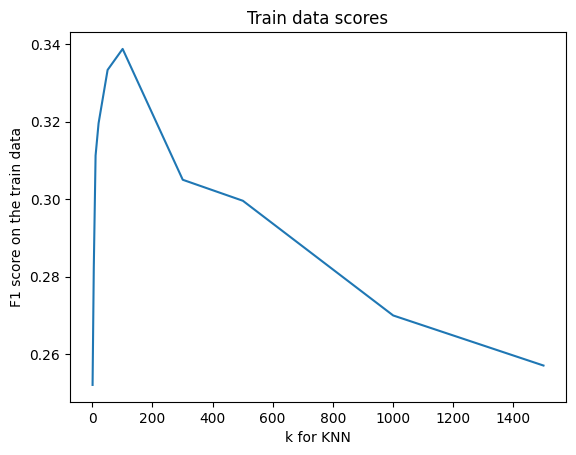

In [440]:
# строим график зависимости f-меры от количества соседей k для тренировочной части данных
m, kern = "manhattan", EPANECHNIKOV_KERNEL
train_scores = []
neigh = NearestNeighbors(n_neighbors=(max(ks) + 1), metric=m)
neigh.fit(data_train)
for k in ks:
    dists_train = neigh.kneighbors(data_train, k + 2)[0][:, -1]
    dists_train = dists_train + (dists_train < EPS) * np.full(dists_train.shape, fill_value=EPS, dtype=np.float64)
    predicted_train = windowed_classification(data_train, target_train, positions, m, dists_train[:, None], kern)
    train_score = f1_score(predicted_train, ind_train_positions, average="micro")
    train_scores.append(train_score)
plt.plot(ks, train_scores)
plt.xlabel('k for KNN')
plt.ylabel('F1 score on the train data')
plt.title("Train data scores")
plt.show()

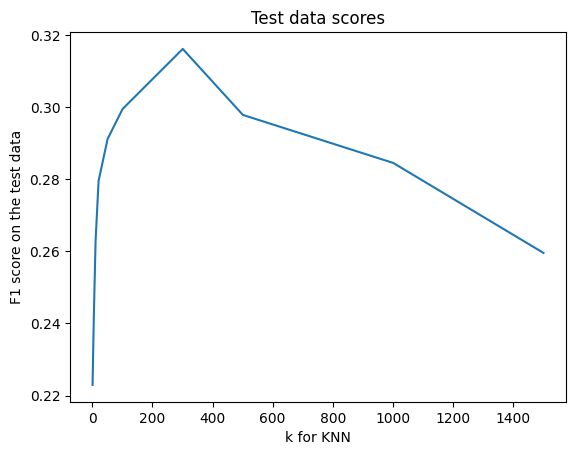

In [441]:
# строим график зависимости f-меры от количества соседей k для тестовой части данных
m, kern = "manhattan", EPANECHNIKOV_KERNEL
test_scores = []
neigh = NearestNeighbors(n_neighbors=(max(ks) + 1), metric=m)
neigh.fit(data_train)
for k in ks:
    dists_test = neigh.kneighbors(data_test, k + 1)[0][:, -1]
    dists_test = dists_test + (dists_test < EPS) * np.full(dists_test.shape, fill_value=EPS, dtype=np.float64)
    predicted_test = windowed_classification(data_train, target_train, positions, m, dists_test[:, None], kern, data_test)
    test_score = f1_score(predicted_test, ind_test_positions, average="micro")
    test_scores.append(test_score)
plt.plot(ks, test_scores)
plt.xlabel('k for KNN')
plt.ylabel('F1 score on the test data')
plt.title("Test data scores")
plt.show()

In [442]:
# Создаём объект NearestNeighbors для поиска соседей в окне известного размера
m, kern, k = "manhattan", EPANECHNIKOV_KERNEL, 101
neigh = NearestNeighbors(n_neighbors=(max(ks) + 1), metric=m)
neigh.fit(data_train)

NearestNeighbors(metric='manhattan', n_neighbors=1502)

In [443]:
# функция взвешивания для LOWESS
def calc_weights(cls_positions, window_sizes, samples=None, cls_samples=None):
    res = []
    for i in tqdm(range(len(window_sizes))):
        if samples is not None:
            cur_cl = cls_samples[i]
        else:
            cur_cl = cls_positions[i]
        neight_sizes = cls_positions[neigh.radius_neighbors(X=samples, radius=window_sizes[i], return_distance=False)[i]]
        cur_cl_amount = (neight_sizes == cur_cl).sum()
        res.append(cur_cl_amount / neight_sizes.shape[0])
    res = 1 - np.array(res)
    return res

In [444]:
# для тренировочной выборки
train_weighted_scores = []
for kern_w in tqdm(KERNELS):  # в LOWESS ядро может отличаться от ядра в kNN, найдём лучшее
    dists_train = neigh.kneighbors(data_train, k + 2)[0][:, -1]
    dists_train = dists_train + (dists_train < EPS) * np.full(dists_train.shape, fill_value=EPS, dtype=np.float64)
    weights = kern_w(calc_weights(ind_train_positions, dists_train))
    predicted_train = windowed_classification(data_train, target_train, positions, m, 
                                              dists_train[:, None], kern, apr_weights=weights)
    train_weighted_score = f1_score(predicted_train, ind_train_positions, average="micro")
    train_weighted_scores.append((train_weighted_score, str(kern_w)))
best_score, best_kern = max(train_weighted_scores)
print(f"Best score with weights:\t{best_score}\n\tKernel:\t{str(best_kern)}")

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2400 [00:00<?, ?it/s]

  0%|          | 0/2400 [00:00<?, ?it/s]

  0%|          | 0/2400 [00:00<?, ?it/s]

  0%|          | 0/2400 [00:00<?, ?it/s]

Best score with weights:	0.3425
	Kernel:	Uniform


In [447]:
print(f"Прирост на тренировочных данных после взвешивания: {best_score - best_non_fixed_width_score}")

Прирост на тренировочных данных после взвешивания: 0.003750000000000031


In [445]:
# для тестовой выборки
test_weighted_scores = []
for kern_w in tqdm(KERNELS):  # в LOWESS ядро может отличаться от ядра в kNN, найдём лучшее
    dists_test = neigh.kneighbors(data_test, k + 1)[0][:, -1]
    dists_test = dists_test + (dists_test < EPS) * np.full(dists_test.shape, fill_value=EPS, dtype=np.float64)
    weights = kern_w(calc_weights(ind_train_positions, dists_test, data_test, ind_test_positions))
    predicted_test = windowed_classification(data_train, target_train, positions, m, 
                                             dists_test[:, None], kern, data_test, weights)
    test_weighted_score = f1_score(predicted_test, ind_test_positions, average="micro")
    test_weighted_scores.append((test_weighted_score, str(kern_w)))
best_score, best_kern = max(test_weighted_scores)
print(f"Best score with weights:\t{best_score}\n\tKernel:\t{str(best_kern)}")

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/601 [00:00<?, ?it/s]

  0%|          | 0/601 [00:00<?, ?it/s]

  0%|          | 0/601 [00:00<?, ?it/s]

  0%|          | 0/601 [00:00<?, ?it/s]

Best score with weights:	0.3011647254575707
	Kernel:	Uniform


In [451]:
print(f"Прирост на тестовых данных после взвешивания: {best_score - test_score}")

Прирост на тестовых данных после взвешивания: 0.0016638935108153063
